# ДЗ 6: Ансамбль

In [1]:
import os
import random
from abc import ABC, abstractmethod
from typing import Dict, List, Tuple, Union

import backtesting
from backtesting import Strategy, Backtest
from backtesting.lib import crossover
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier,
                            StackingClassifier, VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow.keras import layers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
import yfinance as yf
import warnings

warnings.filterwarnings('ignore')

# Set environment variable for deterministic PyTorch behavior
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

# Set seed for reproducibility
SEED = 777

c:\tools\Anaconda3\Lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## Define Data Loading System

We implement a base class for data loading and a synthetic data loader for our experiments.

In [2]:
class DataLoaderBase(ABC):
    """Base class for data loading interface"""
    
    @abstractmethod
    def load_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """Load data and return features and labels"""
        pass

class SyntheticDataLoader(DataLoaderBase):
    """Load synthetic data for ML experiments"""
    
    def __init__(self, n_samples: int = 1000, n_features: int = 4,
                 n_informative: int = 2, n_redundant: int = 2,
                 random_state: int = None):
        self.n_samples = n_samples
        self.n_features = n_features
        self.n_informative = n_informative
        self.n_redundant = n_redundant
        self.random_state = random_state
        
    def load_data(self) -> Tuple[np.ndarray, np.ndarray]:
        X, y = make_classification(
            n_samples=self.n_samples,
            n_features=self.n_features,
            n_informative=self.n_informative,
            n_redundant=self.n_redundant,
            random_state=self.random_state,
            shuffle=False
        )
        return X, y

## Define CNN Classifier

We create a CNN classifier that follows scikit-learn's estimator interface for ensemble integration.

In [3]:
class CNNClassifier:
    """CNN classifier that follows scikit-learn's estimator interface"""
    
    def __init__(self, input_shape: int = None, random_state: int = None,
                 epochs: int = 10, batch_size: int = 32,
                 conv1_filters: int = 32, conv2_filters: int = 64,
                 dense_units: int = 64, dropout_rate: float = 0.5):
        self.input_shape = input_shape
        self.random_state = random_state
        self.epochs = epochs
        self.batch_size = batch_size
        self.conv1_filters = conv1_filters
        self.conv2_filters = conv2_filters
        self.dense_units = dense_units
        self.dropout_rate = dropout_rate
        self.classes_ = None
        self.model = None
        
    def get_params(self, deep: bool = True) -> dict:
        """Get parameters for this estimator."""
        return {
            'input_shape': self.input_shape,
            'random_state': self.random_state,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'conv1_filters': self.conv1_filters,
            'conv2_filters': self.conv2_filters,
            'dense_units': self.dense_units,
            'dropout_rate': self.dropout_rate
        }
    
    def set_params(self, **params) -> 'CNNClassifier':
        """Set the parameters of this estimator."""
        for key, value in params.items():
            if not hasattr(self, key):
                raise ValueError(f'Invalid parameter {key} for estimator {self.__class__.__name__}')
            setattr(self, key, value)
        return self
        
    def _build_model(self):
        if self.random_state is not None:
            tf.random.set_seed(self.random_state)
            
        model = tf.keras.Sequential([
            layers.Reshape((self.input_shape, 1), input_shape=(self.input_shape,)),
            layers.Conv1D(self.conv1_filters, 3, activation='relu', padding='same'),
            layers.MaxPooling1D(2),
            layers.Conv1D(self.conv2_filters, 3, activation='relu', padding='same'),
            layers.MaxPooling1D(2),
            layers.Flatten(),
            layers.Dense(self.dense_units, activation='relu'),
            layers.Dropout(self.dropout_rate),
            layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model
    
    @property
    def _estimator_type(self):
        return "classifier"
    
    def fit(self, X, y):
        """Fit the model to the data"""
        # Initialize model if not already done
        if self.model is None:
            self.model = self._build_model()
            
        # Store unique classes
        self.classes_ = np.unique(y)
        if len(self.classes_) != 2:
            raise ValueError("CNNClassifier only supports binary classification")
            
        # Convert labels to 0/1
        y_binary = (y == self.classes_[1]).astype('float32')
        
        # Fit the model
        self.model.fit(
            X, y_binary,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=0
        )
        return self
    
    def predict_proba(self, X):
        """Predict class probabilities"""
        if self.model is None:
            raise ValueError("Model has not been fitted yet.")
        
        probs = self.model.predict(X, verbose=0).flatten()
        return np.column_stack([1 - probs, probs])
    
    def predict(self, X):
        """Predict class labels"""
        probas = self.predict_proba(X)
        return self.classes_[np.argmax(probas, axis=1)]

## Define Model Evaluator

This class helps us evaluate and compare different models' performance.

In [4]:
class ModelEvaluator:
    """Evaluate and compare model performances"""
    
    @staticmethod
    def evaluate_model(model, X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
        """Calculate various metrics for model evaluation"""
        y_pred = model.predict(X_test)
        return {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }
    
    @staticmethod
    def plot_model_comparison(model_metrics: Dict[str, Dict[str, float]]) -> None:
        """Plot performance comparison of different models"""
        metrics = ['accuracy', 'precision', 'recall', 'f1']
        models = list(model_metrics.keys())
        
        x = np.arange(len(metrics))
        width = 0.8 / len(models)
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for i, model_name in enumerate(models):
            performance = [model_metrics[model_name][metric] for metric in metrics]
            ax.bar(x + i * width, performance, width, label=model_name)
        
        ax.set_ylabel('Score')
        ax.set_title('Model Performance Comparison')
        ax.set_xticks(x + width * (len(models) - 1) / 2)
        ax.set_xticklabels(metrics)
        ax.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

## Set Random Seed

Set random seeds for reproducibility across all libraries.

In [5]:
def seed_everything(seed: int = 42) -> None:
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    print(f"Using {seed} seed")

# Set the seed
seed_everything(SEED)

Using 777 seed


## Load and Prepare Data

In [6]:
# Initialize data loader
data_loader = SyntheticDataLoader(
    n_samples=1_000,
    n_features=4,
    n_informative=2,
    n_redundant=2,
    random_state=SEED
)

# Load and split data
X, y = data_loader.load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED)

## Create and Train Models

In [7]:
# Create base models
base_models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=SEED),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=SEED),
    'CNN': CNNClassifier(input_shape=X.shape[1], random_state=SEED)
}

# Create voting ensemble with soft voting (since CNN outputs probabilities)
voting_clf = VotingClassifier(estimators=[
    ('lr', base_models['Logistic Regression']),
    ('rf', base_models['Random Forest']),
    ('gb', base_models['Gradient Boosting']),
    ('cnn', base_models['CNN'])], voting='soft')

# Train all models
model_metrics = {}
evaluator = ModelEvaluator()

# Train and evaluate base models
for name, model in base_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    model_metrics[name] = evaluator.evaluate_model(model, X_test, y_test)

# Train and evaluate ensemble
print("Training Voting Ensemble...")
voting_clf.fit(X_train, y_train)
model_metrics['Voting Ensemble'] = evaluator.evaluate_model(voting_clf, X_test, y_test)

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training CNN...
Training Voting Ensemble...


## Display Results


Model Performance Metrics:

Logistic Regression:
accuracy: 0.9333
precision: 0.8919
recall: 0.9706
f1: 0.9296

Random Forest:
accuracy: 0.9533
precision: 0.9420
recall: 0.9559
f1: 0.9489

Gradient Boosting:
accuracy: 0.9467
precision: 0.9286
recall: 0.9559
f1: 0.9420

CNN:
accuracy: 0.9533
precision: 0.9178
recall: 0.9853
f1: 0.9504

Voting Ensemble:
accuracy: 0.9600
precision: 0.9189
recall: 1.0000
f1: 0.9577


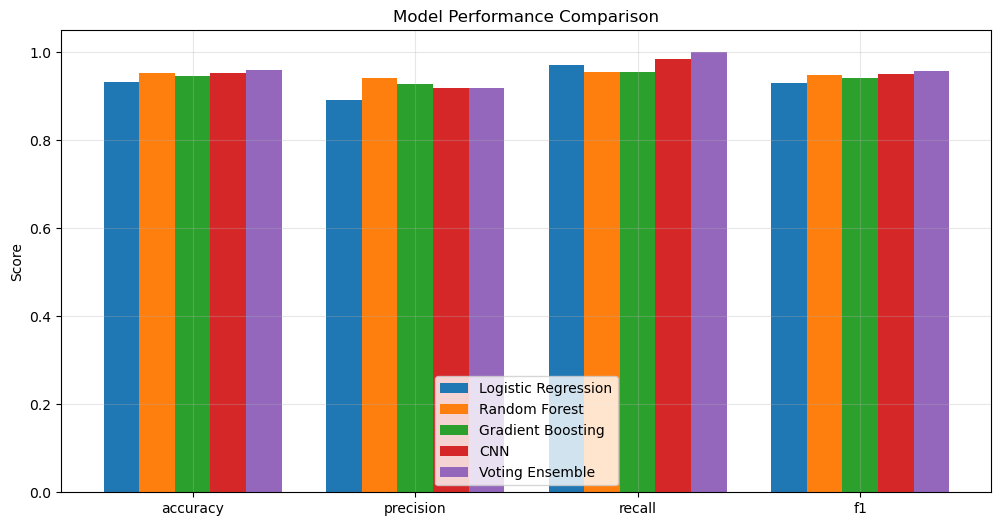

In [8]:
# Print metrics
print("\nModel Performance Metrics:")
for model_name, metrics in model_metrics.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

# Plot performance comparison
evaluator.plot_model_comparison(model_metrics)